<a href="https://colab.research.google.com/github/JahaanRawat/Machine_leanring_projects_school/blob/main/a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC421 Assignment 2: Convolutional Networks

**Deadline**: March 5, 2021 by 10pm

**Submission**: Submit a PDF report containing your code, outputs,
and your written solutions.
You may export the completed notebook, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
February 5, 10pm, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.


In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import math

## Question 1. Data

We will be releasing the combined assignment 2 data set from the entire
class on Quercus. There will be an announcement with the data set is posted.
You can complete coding Q1 even before the data set is released. In fact,
we recommend testing your code with just your own set of shoes, so the code
runs faster!


There will be three main folders in the file:
`train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets.

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images
from 10 students who submitted images of either exclusively men's shoes or women's shoes.

If you are using Google Colab, upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section (ideally this entire handout)
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 1 pts

Why might we care about the accuracies of the men's and women's shoes as two
separate measures? Why would we expect our model accuracies for the two groups
to be different?

Recall that your application may help people who are visually impaired.

In [ ]:
# Your answer goes here. Please make sure it is not cut off

There are many different shoe types. Casual shoes, sport shoes, high heels, army boots, etc.
If we want to make sure our model can perform well, we cannot only check the accuracy for 
casual shoes. We need to check accuracies for al kinds, to see where our model performs 
well and where it does not.

Similarly, in our problem, we need to check men and women shoes accuracies to see where our
model underperforms. Thus, using these accuracies, we can try to improve it. For example,
we could add more women shoes to train set.

Majority of our train set consists of men shoes. Thus, our model would train 
better for men shoes. Consequently, we expect our model to have higher accuracies for men 
shoes compared to women shoes.

### Part (b) -- 4 pts

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training! (why??)**

This function might take a while to run---it might take 3-4 minutes just to load the files from Google Drive.
If you want to avoid running this code multiple times, you can save your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files
import os.path #to check if a file exist, thus it will only load images if numpy.array does not exists
import glob

def readImages(folder):
  """
  Reads the images from `folder` at /content/gdrive/My Drive/CSC413/A2/413data/ using 
  google drive. This function returns one value: dictionary of images with filenames for 
  keys and arrays of rgbs for values.

  Example Usage:

  >>> images = readImages("train")
  """
  path = "/content/gdrive/My Drive/CSC413/A2/413data/"+folder+"/*.jpg" # edit me
  images = {}
  for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel
  return images


def parseImages(images):
  """
  Parses images into numpy arrays
  """
  number_users = len(images)//6
  dataset = np.empty([number_users, 3, 2, 224, 224, 3], dtype=float)
  counter = 0;
  for i in sorted (images.keys()):
    if counter ==66:
      print(i)
      print(i)
      print(i)
      print(i)
      print(i)
    data = images[i]
    args = i.split("_")
    user_index = counter//6
    pair_index = int(args[1])
    is_right = int('right' == args[2])
    # We substract 0.5 from the floats so the RGB set is balanced
    dataset[user_index,pair_index,is_right,:,:,:] = (data[:,:,:]/255)-0.5 
    counter+=1
  return dataset
def loadData(fname): #
  """
  Checks if the images are already parsed and saved, 
  if yes loads them, 
  if not parses them and saves them
  """
  dataset = 0
  if os.path.isfile('/content/gdrive/My Drive/CSC413/A2/413data/'+fname+'.npy'):
    with open('/content/gdrive/My Drive/CSC413/A2/413data/'+fname+'.npy', 'rb') as f:
      dataset = np.load(f)
  else:
    images = readImages(fname)
    dataset = parseImages(images)
    with open('/content/gdrive/My Drive/CSC413/A2/413data/'+fname+'.npy', 'wb') as f:
        np.save(f, dataset)
  return dataset
train_data = loadData('train')
test_m = loadData('test_m')
test_w = loadData('test_w')
# We want to split 20% of our train_data for validation_data. 20% of 107 is 22. 
#train_data will have size of 85 and validation_data will have size of 22 
validation_data = train_data[-22:]
train_data = train_data[:85]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


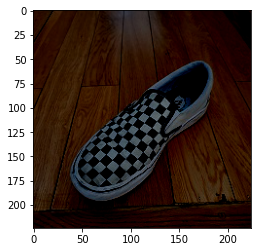

In [ ]:
# I had to seperate these 3 pictures apart from each as they were not showing in pdf
# Run this code, include the image in your PDF submission
plt.figure() 
plt.imshow(train_data[58,1,1,:,:,:]) # left shoe of first pair submitted by 5th student

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


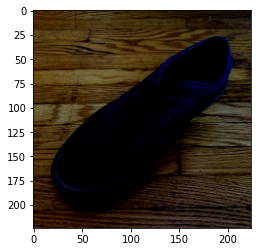

In [ ]:
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


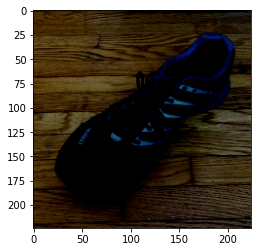

In [ ]:
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (c) -- 2 pts

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take as input an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in part (c).

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

(Later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires)

(85, 3, 2, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(255, 448, 224, 3)


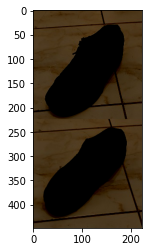

In [ ]:
# Your code goes here

def generate_same_pair(dataset):
  """
  Generates image of two shoes of same pair together
  """  
  dataset_reshaped = dataset.reshape([dataset.shape[0]*3, 2, 224, 224, 3])
  left_shoes = dataset_reshaped[:, 0, :, :, :]
  right_shoes = dataset_reshaped[:, 1, :, :, :]
  return np.concatenate([left_shoes, right_shoes], axis=1)
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.figure()
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair


### Part (d) -- 2 pts

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each student image submissions, there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(85, 3, 2, 224, 224, 3)
(255, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


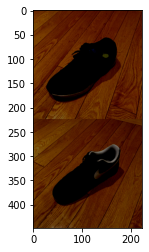

In [ ]:
# Your code goes here
def generate_different_pair(dataset):
    """
    Generates image of two shoes of different pairs together
    """
    def concatenate_data(pairs):
        """
        Helper function for concatenating data
        """
        dif_first = np.concatenate(pairs[0], axis=1)
        dif_second = np.concatenate(pairs[1], axis=1) 
        dif_third = np.concatenate(pairs[2], axis=1)
        new_data = np.concatenate([dif_first, dif_second, dif_third], axis=0)
        return new_data

    left0 = dataset[:, 0, 0, :, :, :]
    left1 = dataset[:, 1, 0, :, :, :]
    left2 = dataset[:, 2, 0, :, :, :]
    right0 = dataset[:, 0, 1, :, :, :]
    right1 = dataset[:, 1, 1, :, :, :]
    right2 = dataset[:, 2, 1, :, :, :]
    possibles = [[left0,right1],[left0,right2],[left1,right0],[left1,right2],
                 [left2,right0],[left2,right1]]
    diffpairs = random.sample(possibles, 3)
    return concatenate_data(diffpairs)
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.figure()
plt.imshow(generate_different_pair(train_data)[11]) # should show 2 shoes from different pairs


### Part (e) -- 1 pts

Why do we insist that the different pairs of shoes still come from the same
student?  (Hint: what else do images from the same student have in common?)

In [ ]:
# Your answer goes here. Please make sure it is not cut off

Each students pictures have different backgrounds, and probably also have different angles, 
different lightings, and different cameras.
We want our Neural Network to only focus on shoes itself, not on the backgrounds. Thus, by 
using the pictures from the same student, we minimize the third variable differences.  

### Part (f) -- 1 pts

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [ ]:
# Your answer goes here. Please make sure it is not cut off

It is important to use balanced data sets because a neural network model would generate 
better accuracy models with them. The main reason for using balanced data sets is to 
remove the bias. Our network makes predictions, and these predictions should not be based 
on probabilities but on the data itself. 

If data sets are not balanced, this will cause a definite bias which will lower the 
test accuracy of a model. If we had 99% of images from different pairs and 1% from same 
pairs, it would train to be biased against same pairs. Consequently, when the model make 
prediction, it would take frequency probability into account instead of focusing on only 
the data and would say pairs are `different` more, as it learns pairs are most of the 
time `different`. By making sure data set is balanced we remove the bias.

## Question 2. 1D Convolutions

In our treatment of convolutional neural networks,
we focused on CNNs for images, which has a 2D geometry.
Other types of data like audio, text, and time series data have a 1D geometry,
and we can use convolutions for those data sets as well.
For audio data, you can think of convolutions
as detecting features in a small region in time.

1D convolutions are simpler numerically, so it is worth
looking at the math and computation behind 1D convolutions
before we analyze 2D convolutions.

Suppose we have audio or time series data that looks like this,
where the target $t$ is binary:

| x | t  |
|------------------------------|-----|
| [1, 2, 3, 1, 0, -1, 3] | 1 |
| [0, 1, 4, 3, 1, 1, 1] | 1 |
| [1, 3, 2, 1, 1, 0, 1] | 0 |

A 1D convolution can be applied by taking a 1D kernel (say [-1, 2, -1]),
and sliding it across the sequence.
At each position, we compute the dot product between the input with the kernel,
like this:

![](1dconv.png){ width=2in }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)

### Part (a) -- 2 pts

Suppose we are building a neural network to classify time series data like the one
above. The architecture we choose will look like this:

- In the first layer, we'll apply a 1D convolution with kernel size 3. The number of
  input channels is 1, and the number of output channels is also 1. We won't use any
  zero padding.
  We'll initialize the weights of this 1D convolution to ${\bf w}^{(1)} = [-1, 2, -1]$
  like in the figure, and initialize the bias to ${\bf b}^{(1)} = 0$.
  We will apply the ReLU activation after this layer.
- In the second layer, we'll have a fully-connected layer. There are 5 input units,
  and a single output unit. We'll initialize all the weights and biase to 1 so 
  $w_k^{(2)} = 1$ and $b^{(2)} = 1$.
- We'll use the cross-entropy loss.

Compute the forward pass for the data point $x = [1, 3, 2, 1, 1, 0, 1]$, $t = 0$

In [ ]:
# Your answer goes here. Make sure to show your work.

$\bf{First\ Layer}$:

\begin{align*}
{(-1)*1 + (2)*3 + (-1)*2} &= {3} \\
{(-1)*3 + (2)*2 + (-1)*1} &= {0} \\
{(-1)*2 + (2)*1 + (-1)*1} &= {-1} \\
{(-1)*1 + (2)*1 + (-1)*0} &= {1} \\
{(-1)*1 + (2)*0 + (-1)*1} &= {-2} \\
\end{align*}

$\bf{Relu}$:
\begin{align*}

x &= [3, 0, -1, 1, -2] \\
\textrm{max}(0,x) &= [3, 0, 0, 1, 0] \\
\end{align*}

$\bf{Second\ Layer}$:
\begin{align*}
w=[[1],[1],[1],[1],[1]] , b=1  \\
w*[3, 0, 0, 1, 0] + b &=  \\
[[1],[1],[1],[1],[1]]*[[3, 0, 0, 1, 0]] + 1 &=  \\
x &= 3+1+1 = 5 \\
\end{align*}

$\bf{Softmax}$:
\begin{align*}
\textrm{softmax}(\bf{z}) &=\frac{e^{(z)_{i}}}{\sum_{k=1}^{N} e^{(z)_{k}}}\\
\textrm{softmax}(\bf{x}) &= \{ \frac{e^{4}}{\sum_{k=1}^{N} e^{(x)_{k}}} ,\frac{e^{1}}{\sum_{k=1}^{N} e^{(x)_{k}}} ,\frac{e^{1}}{\sum_{k=1}^{N} e^{(x)_{k}}} ,\frac{e^{2}}{\sum_{k=1}^{N} e^{(x)_{k}}} ,\frac{e^{1}}{\sum_{k=1}^{N} e^{(x)_{k}}} \}\\
 &= \{ \frac{54.598}{70.142} ,\frac{2.718}{70.142} ,\frac{2.718}{70.142} ,\frac{7.389}{70.142} ,\frac{2.718}{70.142} \}\\
 &= \{ 0.7783, 0.0387 , 0.0387 , 0.1053 ,0.0387 \}\\
\end{align*}

$\bf{Cross\ Entrophy\ Loss}$:

$L(y,t) = −t log(y) − (1 − t)log(1 − y)$ \\
$\text{If } t =0:$ \\
$L(y,0) = − log(1 − y)$ \\
$L(x,0) = −log(1 − 0.7783)−log(1 − 0.0387)−log(1 − 0.0387)−log(1 − 0.1053)$ \\
$−log(1 − 0.0387)$ \\
$L(x,0) = 0.654418426+0.017165433+0.017165433+0.048322562+0.017165433$ \\
 $ = 0.754258730$ \\

$\bf{Output}$:
\begin{align*}
&= 0.75425873021
\end{align*}

### Part (b) -- 3 pts

Use backpropagation to compute the error signal $\overline{{\bf w}^{(1)}}$ of the
1D convolution kernel for the same single data point $x = [1, 3, 2, 1, 1, 0, 1]$, $t = 0$.
Show your steps.
You do not need to compute the error signal for the other parameters.

In [ ]:
# Your answer goes here. Make sure to show your work.

Backpropagation of Cross Entrophy Loss and Softmax:
dE/z2 = softmax(x)_k - t_k
As t is = 0, dE/z2 is just the softmaxes.
dE/z2 = {0.7783,0.0387,0.0387,0.1053,0.0387}

Backpropagation of Second Layer:
dE/z2 * dz/x2 = dE/z * w2  = dE/z * 1 = dE/z

Backpropagation of Relu:
if x>0 relu' = 1
else relu' = 0
relu' = {1,1,1,1,1}

dE/x2 * dx2/dz1 = {0.7783,0.0387,0.0387,0.1053,0.0387} * {1,1,1,1,1}

Backpropagation of First Layer: # For each weight, taking the inputs they were multiplied with
dE/z1 * dz/w_1 = dE/z1  * x_1 = {0.7783,0.0387,0.0387,0.1053,0.0387} * {1,3,2,1,1}
dE/z1 * dz/w_2 = dE/z1  * x_2 = {0.7783,0.0387,0.0387,0.1053,0.0387} * {3,2,1,1,0}
dE/z1 * dz/w_3 = dE/z1  * x_3 = {0.7783,0.0387,0.0387,0.1053,0.0387} * {2,1,1,0,1}

(1)*0.7783 + (3)*0.0387 + (2)*0.0387 + (1)* 0.1053 + (1)*0.0387 = 1.115
(3)*0.7783 + (2)*0.0387 + (1)*0.0387 + (1)* 0.1053 + (0)*0.0387 = 2.5563
(2)*0.7783 + (1)*0.0387 + (1)*0.0387 + (0)* 0.1053 + (1)*0.0387 = 1.6727
error signal => [1.115,2.5563,1.6727]

### Part (c) -- 3 pts

1D convolutions can be and have been used for language modeling, where the sequence
${\bf x}$ represents a sequence of *words* in a sentence. Our target can
represent (for example) whether a sentence conveys positive or negative
sentiment.

The way we typically represent each *word* is either using a one-hot embedding
(like in Assignment 1) or using distributed representations (like the one we learned
in Assignment 1). In either case, each word will be represented using a vector. Here
is a representation of a sentence ${\bf x} = w_1, w_2, \cdots, w_T$ using one-hot
vectors:

| $w_1$ | $w_2$ | $w_3$ | $\cdots$  | $w_T$ |
|------|-----|-----|-----|-----|
| 0 | 0 | 0 | $\cdots$ | 1 |
| 1 | 0 | 0 | $\cdots$ | 0 |
| 0 | 0 | 0 | $\cdots$ | 0 |
| 0 | 1 | 0 | $\cdots$ | 0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| 0 | 0 | 0 | $\cdots$ | 0 |

In particular, we can represent ${\bf x}$ as a matrix of shape $V \times T$, where $V$
is the size of the vocabulary and $T$ is the length of the sentence. This representation
of ${\bf x}$ looks like a 2D, greyscale image!

Explain why it is *not* actually reasonable to use a 2D convolutional kernel
(e.g., a 3x3 kernel like earlier) on this data.  (1.5pt)

What kind of computation should we use instead so that
a 1D convolution can take account of the fact that each word $w_j$ is a
$V$-dimensional vector? (1.5 pt)

In [ ]:
The input matrix is the one hot representation of the words where each column is a word of
the sentence. Using 2D convolutional kernel would not extract usefull features because it 
would not include the one hot encoding when activated in general. Moreover the output after 
using 2D kernel would not represent 1D output . Ideally the size of the kernel should be 
n x V and n can vary between 2 to 5 depedning on the length of the sentence. This would 
include the one hot encoding of ther word and be activated on multiple words. Also, the 
output here would be 1D as required. 

### Part (d) -- 2 pts

In this problem we will look at the $\textit{effective receptive field}$ that results from a sequence of 1D convolutions.
Consider a 1D convolution with kernel width $K$.
The diagram below illustrates how the effective receptive field grows as we perform a chain of convolutions.

![](CSC413_1D_Conv.png){ width=200px }

Let the kernel width be $K$ (i.e., $K=3$ in the diagram above, but we will consider arbitrary $K$).

What is the width of the effective receptive field of a unit in the $N^{th}$ layer?

Your answer should be expressed as a closed-form equation involving the variables $K$ and $N$.

$\textbf{Answer}$ \\
If kernel width was $3$, the width of the effective receptive field of a unit would increase by $2$ for each layer. If kernel width was $5$, the width of the effective receptive field of a unit would increase by $4$ for each layer. Overall, If kernel width is any number($K$), width of the effective receptive field of a unit would increase by $K-1$ for each layer.

Considering $N$ is number of hidden layers, in the $N^{th}$ layer width of the effective receptive field for each unit would be equal to $N*(K-1)+1$

## Question 3. CNN Implementation

Before starting this question, we recommend reviewing the lecture materials
on convolutional neural networks, including the demo from lecture 5.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 3 pts

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $n \times 2$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $n \times 2$ channels, and outputs $n \times 4$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $n \times 4$ channels, and outputs $n \times 8$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the lecture, tutorial, and assignment
materials to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        kernel = 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))
        self.fc = nn.Linear(n*8* 28* 14, 100)
        self.fc2 = nn.Linear(100, 2)
    def forward(self, x):
        #x = x.reshape([1,3,448,224])
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, x.shape[1]* x.shape[2]* x.shape[3])
        x = self.fc(x)
        return self.fc2(x)


### Part (b) -- 3 pts

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

![](https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png){ width=400px }
<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        kernel = 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=kernel,
                               padding=((kernel - 1) // 2))

        self.fc = nn.Linear(n*8*14*14, 100)
        self.fc2 = nn.Linear(100, 2)
    def forward(self, x):
        xleft = x[:,:,:224,:] 
        xright = x[:,:,224:,:] 
        x = torch.cat((xleft, xright), 1)
        #x = x.reshape([1,6,224,224])
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, x.shape[1]* x.shape[2]* x.shape[3])
        x = self.fc(x)
        return self.fc2(x)

## Part (c) -- 2 pts

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (just like in Assignment 1). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is a standard practice in machine learning because
this architecture performs better!

Explain why this architecture will generally give us better performance.

In [ ]:
# Your answer goes here. Please make sure it is not cut off

## Part (c) -- 2 pts
In CrossEntropyLoss the losses are averaged across observations for each minibatch which 
reduces computational time. Similar to BCEWithLogitsLoss the use of log probabilites ensures 
numerical stability, however in CrossEntropyLoss the variations in gradients tends to be 
lower compared to BCEWithLogits and this helps in imporoving times for gradient descent.  

### Part (d) -- 3 pts

Compute the number of parameters in your `CNN` and `CNNChannel` models.
You should do this computation step-by-step manually, rather than trying to find
a PyTorch function to do it for you. This value should be a function of $n$ 
and the kernel size $k$ that you chose (either 3 or 5).

In [ ]:
# Your answer goes here. Show your work.
We know that: 
i = feature maps of input
o = feature maps of output
k*k = filter size
Convolutional Layer Parameters = (k*k*i+1)*o
Pooling Layers = Zero parameters
Fully Connected Layers = (inputs+1) * outputs


CNN:

#     name            size                         parameters
--- ------   ---------------   -------------------------------
 1)  Input = 3 * 448 * 224
 2)  Conv1 = n * 448 * 224     = (k*k*3+1)*n     = 3*n*k^2 + n
 3)  Pool1 = n * 224 * 112     = 0
 4)  Conv2 = n*2 * 224 * 112   = (k*k*n+1)*n*2   = 2*k^2*n^2 + 2*n
 5)  Pool1 = n*2 * 112 * 56    = 0
 6)  Conv3 = n*4 * 112 * 56    = (k*k*n*2+1)*n*4 = 8*k^2*n^2 + 4*n
 7)  Pool1 = n*4 * 56 * 28     = 0
 8)  Conv4 = n*8 * 56 * 28     = (k*k*n*4+1)*n*8 = 32*k^2*n^2 + 8*n
 9)  Pool1 = n*8 * 28 * 14     = 0
 10)  fc1  = 100               = (3136*n+1)*100  = 313600*n + 100
 11)  fc2  = 2                 = (100+1) *2      = 202 

Total = 42*k^2*n^2 + 3*n*k^2 + 313615*n + 302

CNNChannel:

#     name            size                         parameters
--- ------   ---------------   -------------------------------
 1)  Input = 6 * 224 * 224
 2)  Conv1 = n * 224 * 224     = (k*k*6+1)*n     = 6*n*k^2 + n
 3)  Pool1 = n * 112 * 112     = 0
 4)  Conv2 = n*2 * 112 * 112   = (k*k*n+1)*n*2   = 2*k^2*n^2 + 2*n
 5)  Pool1 = n*2 * 56 * 56    = 0
 6)  Conv3 = n*4 * 56 * 56    = (k*k*n*2+1)*n*4  = 8*k^2*n^2 + 4*n
 7)  Pool1 = n*4 * 28 * 28     = 0
 8)  Conv4 = n*8 * 28 * 28     = (k*k*n*4+1)*n*8 = 32*k^2*n^2 + 8*n
 9)  Pool1 = n*8 * 14 * 14     = 0
 10)  fc1  = 100               = (1568*n+1)*100  = 156800*n + 100
 11)  fc2  = 2                 = (100+1) *2      = 202 

Total = 42*k^2*n^2 + 6*n*k^2 + 156815*n + 302

## Part (e) -- 2 pts

From part (d), you should see that the two models have roughly the same number
of parameters.  However, one of these models will perform better,
showing that architecture choices **do** matter in machine learning.
Explain why one of these models performs better.

In [ ]:
By increasing the number of input channels as seen in CNNChannel more
kernels will be required which may help to identitfy more features and improve
accuracy.

## Part (f) -- 4 pts

For this question, let's consider the `CNNChannel` model.
Consider a hidden unit directly **after** the first downsampling operation.
What is the *receptive field* of a unit close to the center of the feature map?
In other words, how many pixels (from one shoe image) affect the activation
value of that unit? (Note: we're studying units from the center of the
feature map/image so you don't have to worry about hitting the image boundary.)

Repeat the same computation for the hidden unit directly after the second,
third, and fourth downsampling operation.

Notice that your answer here is very different from your answer from Q2(d).
The key difference is the **downsampling** operations that we are performing.
Because of these downsampling operations, later
layers can detect features from a large portion of the input.

$\textbf{Answer}$ \\
If kernel width was $3$, the width of the effective receptive field of a unit would increase by $2$ for each layer. If kernel width was $5$, the width of the effective receptive field of a unit would increase by $4$ for each layer. Overall, If kernel width is any number($K$), width of the effective receptive field of a unit would increase by $K-1$ for each layer.

Everytime downsampling happens, receptive field of that unit is multiplied by $4$. (Considering downsampling is $2\times2$)

In [ ]:
Input of CNNChannel = 6 * 224 * 224

After Conv1 with kernel_size = 3x3, input becomes n*224*224, as we are looking for a unit 
close to the center padding is not our concern.
Receptive field of a unit is = 3x3
After downsampling or pooling in our case.
Receptive field of a unit is = 6x6

After Conv2 with kernel_size = 3x3.
Receptive field of a unit is = 8x8
After downsampling.
Receptive field of a unit is = 16x16

After Conv3 with kernel_size = 3x3.
Receptive field of a unit is = 18x18
After downsampling.
Receptive field of a unit is = 36x36

After Conv4 with kernel_size = 3x3.
Receptive field of a unit is = 38x38
After downsampling.
Receptive field of a unit is = 76x76

## Part (g) -- 2 pts

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in assignment 1, we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track these
two values separately.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
We want to see the accuracies for "Positive Positive", "Positive Negative", 
"Negative Positive", and "Negative Negative".

In other words, we want to see the accuracy on positive samples, so we can see which positive
samples are considered `negative` for our model, thus we can use that information to fix it.

Plus, it is also important that our model realizes when two shoes are from different pairs. 
If we only check the accuracy for positive samples, we could have a simple program that 
would say all pairs are from same pair and get 100% accuracy. 

We need a program that has high accuracy for both same pair shoes and different pairs shoes.
Therefore, to achieve this we need to trach model accuracy for both positive and negative samples.

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3).transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3).transpose(2, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 4. Training

Now, we will write the functions required to train the model.

### Part (a) -- 8 pts

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in assignment 1, but with a major difference in the way we treat our training data.

Since our positive and negative training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data! In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here's what we will be looking for:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions "NCHW",
  use the `.transpose()` method in either PyTorch or numpy
- computing the forward and backward passes
- after every epoch, checkpoint your model (A1 had in-depth instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

In [ ]:
def train_model(model, 
                training_data, 
                val_data, 
                batch_size, 
                learning_rate,
                weight_decay,
                max_iters,
               checkpoint_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses_pos, losses_neg = [], [], []
    iters_sub, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg = [], [] ,[], [], []
    

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            
            model.train() # annotate model for training    
            data_pos = generate_same_pair(training_data)      # should have shape [n * 3, 448, 224, 3]
            np.random.shuffle(data_pos)              # shuffle the data
            data_neg = generate_different_pair(training_data) # should have shape [n * 3, 448, 224, 3]
            np.random.shuffle(data_neg)              # shuffle the data
            
            # setting the size of the batch
            size_batch = batch_size//2
  
            # convert from numpy arrays to PyTorch tensors for positive values
            xs_pos = torch.Tensor(data_pos[:size_batch]).transpose(1, 3).transpose(2, 3)
            # get positive labels
            ts_pos = torch.ones(size_batch, dtype=torch.long)
            # convert from numpy arrays to PyTorch tensors for negative values
            xs_neg = torch.Tensor(data_neg[:size_batch]).transpose(1, 3).transpose(2, 3)
            # get negative labels
            ts_neg = torch.zeros(size_batch, dtype=torch.long)
            # combine
            xs = torch.cat((xs_pos, xs_neg), 0)
            ts = torch.cat((ts_pos, ts_neg), 0)
            zs = model(xs)
            
            
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter

            if n % batch_size == 0:
                iters_sub.append(n)
                loss = float(loss.detach().numpy())
                train_acc_pos, train_acc_neg = get_accuracy(model, training_data, size_batch)
                train_accs_pos.append(train_acc_pos)
                train_accs_neg.append(train_acc_neg)
                val_acc_pos, val_acc_neg = get_accuracy(model, val_data)
                val_accs_pos.append(val_acc_pos)
                val_accs_neg.append(val_acc_neg)
                print("Iter %d. [Val Pos Acc %.0f%%] [Val Neg Acc %.0f%%] [Train Pos Acc %.0f%%] [Train Neg Acc %.0f%%] [loss %.0f]"  % (
                      n, val_acc_pos * 100, val_acc_neg * 100, train_acc_pos * 100, train_acc_neg * 100, loss))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses_pos, losses_neg, iters_sub, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg     

### Part (b) -- 2 pts

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can "memorize" a very small subset of the training set (e.g. 5 images). That is,
show that your model can achieve 90%+ accuracy relatively quickly (within ~50 or so iterations)
on a training set size of ~5 images.

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.

(If you have trouble with CNN() but not CNNChannel(), try reducing $n$, e.g. try working
with the model `CNN(2)`)

In [ ]:
# Write your code here. Remember to include your results so that your TA can
# see that your model attains a high training accuracy.



#model = CNN()
model = CNNChannel()
training_data = train_data[:5]
val_data = train_data[:5]
batch_size = 5
weight_decay = 0.0
max_iters = 50
learning_rate = 0.001
iters, losses_pos, losses_neg, iters_sub, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg = train_model(model,training_data,val_data,batch_size,learning_rate,weight_decay,max_iters)



Iter 0. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%] [Train Neg Acc 0%] [loss 1]
Iter 5. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%] [Train Neg Acc 0%] [loss 1]
Iter 10. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%] [Train Neg Acc 100%] [loss 1]
Iter 15. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%] [Train Neg Acc 100%] [loss 1]
Iter 20. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%] [Train Neg Acc 0%] [loss 1]
Iter 25. [Val Pos Acc 93%] [Val Neg Acc 13%] [Train Pos Acc 93%] [Train Neg Acc 13%] [loss 1]
Iter 30. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%] [Train Neg Acc 0%] [loss 1]
Iter 35. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%] [Train Neg Acc 0%] [loss 1]
Iter 40. [Val Pos Acc 73%] [Val Neg Acc 20%] [Train Pos Acc 73%] [Train Neg Acc 27%] [loss 1]
Iter 45. [Val Pos Acc 33%] [Val Neg Acc 67%] [Train Pos Acc 33%] [Train Neg Acc 73%] [loss 1]
Iter 50. [Val Pos Acc 93%] [Val Neg Acc 0%] [Train Pos Acc 93%

### Part (c) -- 4 pts

Train your models from Q2(a) and Q2(b). You will want to explore the effects of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and potentially
the kernel size. You do not need to check all values for all hyperparameters. Instead,
get an intuition about what each of the parameters do.

In this section, explain how you tuned your hyperparameters.

In [ ]:
# Include the training curves for the two models.
In our first tests, our model either gave us 0% accuracy or 100% accuracy. To fix this issue,
we have increased the number of epochs to train.

At the begining our learning_rate was also 1 for quick training. Of course, this made the 
results unstable and unpredictable. We have decrased our learning_rate to slow down the t
raining process, which in result also increases the stability, train the weights to more 
optimal values.

For the batch_size, we chose a default value of 64. Our model has 107 different users, with 
each having 3 pairs of shoes. Small batch_size values would increase the training speed, 
but it would create noise. Larger values would decrease the training speed, but it would have
better accuracy. We have also tried 32, but decided that 64 was a better fit.

Similar to batch_size, having bigger kernel size means less layers and faster increase of 
effective receptive field of a unit, would result in faster training, but may decrease the
accuracy. Thus, instead of using 5, we decided to use 3 for our kernel_size.

### Part (d) -- 2 pts

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in the next question.

In [ ]:
# Helper function for plotting the curves
def plot_learning_curve(iters, iters_sub, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Accuracy per Iteration Postive")
    plt.plot(iters_sub, train_accs_pos, label="Train")
    plt.plot(iters_sub, val_accs_pos, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Learning Curve: Accuracy per Iteration Negative")
    plt.plot(iters_sub, train_accs_neg, label="Train")
    plt.plot(iters_sub, val_accs_neg, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


## Question 5. Test Accuracy

### Part (a) -- 3 pts

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the checkpoint of the model
architecture that produces the best validation accuracy. That is,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report

### Part (b) -- 1 pts

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

In [ ]:
# Make sure both your code and image are visible to the TA

#Our test accuracy was not 100% on the men's shoes test set

### Part (c) -- 1 pts

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

In [ ]:
# Make sure both your code and image are visible to the TA

#Our test accuracy was not 100% on the women's shoes test set

## Question 6. Graph Neural Networks

In this question, we will introduce a relatively new type of neural network
that generalizes convolutions, namely Graph Neural Networks (GNNs).

Recall that a *graph* is a pair $G = (V, E)$ consisting of a set of *vertices*
(also called *nodes*) $V$ and a set of *edges* $E$.
Each edge is a pair of vertices, denoting a connection between them in the graph.
For example, the graph below is represented by the sets
$V = \{ v_1, v_2, v_3, v_4 \}$ and $E = \{ (v_1, v_2), (v_2, v_3), (v_2, v_4), (v_3, v_4) \}$.
We will only consider undirected graphs for this question,
so the ordering of the nodes in each edge is not important.

![](CSC413_ExampleGraph.png){ width=200px }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)


Many different types of structured data can be represented by graphs.
In particular, an image can be represented by a grid-structured graph!
Each node represents a pixel, and edges represent adjacency between pixels in space.

Graph Neural Networks (GNNs) generalize convolutions for arbitrary graph-structured data.
Each node is associated with a vector representation (like the RGB representation of a pixel).
A "layer" in a GNN updates the representation of each node $v$ by taking a linear
combination of the representations of its neighbours $u \in N(v)$
(just like how a 3x3 convolution updates a pixel's representation by taking
a linear combinations of the pixel's 8 direct neighbours, plus the pixel itself!).

If we denote the representation at node $v$ after the $\ell^{th}$ layer by
$\mathbf{h}_v^{(l)}$, then its representation after a GNN update is:

$$\mathbf{h}_v^{(l+1)} = f\left( \sum_{u \in N(v) \cup \{ v \}} \mathbf{W}^{(l+1)} \mathbf{h}^{(l)}_u \right)$$

Here, $f$ is a nonlinearity such as ReLU, and $\mathbf{W}^{(l+1)}$ are the
parameters of the $(l+1)^{th}$ layer of the GNN.

After $k$ GNN layers, each node's representation is affected by other nodes
within a $k$-hop radius (this is similar to the receptive field analysis
from earlier).
Deeper models are able to extract higher-level representations for each node by
aggregating information from larger neighbourhoods.

There are two main types of prediction tasks we may want to perform on graphs:
*node-level* (is this pixel a part of a cat?) and *graph-level* (is this molecule,
represented by this entire graph, be useful for treating a disease?).
We can obtain a representation of an entire graph by 
aggregating the final representations of each node in the graph.

For the rest of this question, we'll assume that we want to make a prediction about
the entire graph. Our GNN will compute a single scalar for the graph:

$$
y = \sigma \left( \mathbf{q}^\top \left( \sum_{v \in V} \mathbf{h}_v \right) \right)
$$
where $\mathbf{q}$ is a vector of the same dimensionality as $\mathbf{h}$ (so that the inner product is a scalar) and the activation $\sigma$ is the logistic sigmoid.


### Part (a) -- 2 pts

In this question, we will be applying graph convolutions by hand in the simple graph
from above. The figure below shows the initial vector representation of each vertex.
(Think of these vectors $h_k^{0}$ as similar to the vector of RGB values at each pixel
in the earlier parts of this assignment.)

![](CSC413_ExerciseGraph.png){ width=300px }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)

Suppose that the parameters of the GNN are as follows:
$$
\mathbf{W} =
\begin{bmatrix}
1 & 2 \\
0 & 1
\end{bmatrix}
% \qquad \qquad
% V =
% \begin{bmatrix}
% 1 & 1 \\
% 1 & 1
% \end{bmatrix}
\qquad \qquad
\mathbf{q} = 
\begin{bmatrix}
1 & 1
\end{bmatrix}
$$

Compute 1 convolutional update step in this graph. 
In other words, find the updated representations for each node after
1 propagation step and report the values $\mathbf{h}^{(1)}_1$,
$\mathbf{h}^{(1)}_2$, $\mathbf{h}^{(1)}_3$, $\mathbf{h}^{(1)}_4$.




In [ ]:
# Your answer goes here. Make sure to show your work.



$$
h^{(1)}_{1} = f \left( \begin{bmatrix}
1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
1 \\
1 
\end{bmatrix} + \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
1 \\
0 
\end{bmatrix} \right)  \\ = f \left( \begin{bmatrix}
3 \\
1 
\end{bmatrix} + \begin{bmatrix}
1 \\
0 
\end{bmatrix} \right) \\ = \begin{bmatrix}
4 \\
1 
\end{bmatrix}
$$

$$
h^{(1)}_{2} = f \left( \begin{bmatrix}
1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
1 \\
1 
\end{bmatrix} + \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
1 \\
0 
\end{bmatrix}+ \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
0 \\
1 
\end{bmatrix}+ \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
-1 \\
0 
\end{bmatrix} \right) \\ = f\left( \begin{bmatrix}
3 \\
1 
\end{bmatrix} + \begin{bmatrix}
1 \\
0 
\end{bmatrix} + \begin{bmatrix}
2 \\
1 
\end{bmatrix}+ \begin{bmatrix}
-1 \\
0 
\end{bmatrix}\right) \\ = \begin{bmatrix}
5 \\
2 
\end{bmatrix}
$$

$$
h^{(1)}_{3} = f\left( \begin{bmatrix}
1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
1 \\
0 
\end{bmatrix} + \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
0 \\
1 
\end{bmatrix}+ \begin{bmatrix}
 1 & 2 \\
0 & 1
\end{bmatrix}  \begin{bmatrix}
-1 \\
0 
\end{bmatrix}\right) \\ = f\left(\begin{bmatrix}
1 \\
0 
\end{bmatrix} + \begin{bmatrix}
2 \\
1 
\end{bmatrix} + \begin{bmatrix}
-1 \\
0 
\end{bmatrix}\right) \\ = \begin{bmatrix}
2 \\
1 
\end{bmatrix}
$$

$$
h^{(1)}_{4} =   \begin{bmatrix}
2 \\
1 
\end{bmatrix}
$$

### Part (b) -- 2 pts

Compute the graph-level output based on the representations you computed in part 1.

In [ ]:
# Your answer goes here. Make sure to show your work.

$$
\mathbf{y} = \sigma \left( \begin{bmatrix}
1 \\ 1 
\end{bmatrix}^T \left( \begin{bmatrix}
4 \\
1 
\end{bmatrix} + \begin{bmatrix}
5\\
2
\end{bmatrix} + \begin{bmatrix}
2 \\
1 
\end{bmatrix} + \begin{bmatrix}
2 \\
1 
\end{bmatrix} \right)\right) \\ = \sigma \left( \begin{bmatrix}
1 \\ 1 
\end{bmatrix}^T \left( \begin{bmatrix}
13 \\
5 
\end{bmatrix}   \right)\right) \\ = \sigma \left( 18 \right) \\ = 0.9999999847700204872397
$$

### Part (c) -- 4 pts

Assume that the target for the graph-level output is $0$,
and that we're using cross-entropy loss. Use backpropagation to compute the gradient of the parameters of the GNN.

In [ ]:
# Your answer goes here. Make sure to show your work.

\begin{align*}
\frac{\partial L}{\partial q} &= \frac{\partial L}{\partial y} \frac{\partial y}{\partial q} \\
\frac{\partial L}{\partial W} &= \frac{\partial L}{\partial y} \left( \frac{\partial y}{\partial h_{1}} \frac{\partial h_{1}}{\partial W} + \frac{\partial y}{\partial h_{2}} \frac{\partial h_{2}}{\partial W} +\frac{\partial y}{\partial h_{3}} \frac{\partial h_{3}}{\partial W} +\frac{\partial y}{\partial h_{4}} \frac{\partial h_{4}}{\partial W}  \right)\end{align*}
Note that if y = 0.9999999847700204872397 and t = 0 
\begin{align*}
\frac{\partial L}{\partial y} 
\end{align*}
will be extremely large.

## Question 7. Work Allocation -- 2 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Your answer goes here

We created our team on Feb 17, planned our work plan. 
For first question, we both solved it ourselves then compared our answers on Feb 20.
For the rest of the assignment, mostly we have worked independently and asked each other 
questions, compared answers.

Necmeddin Ucar:
I read over the assignment on Feb 17. I had some catching up to do, did them by 
Feb 19. I worked on question 1 on the night of Feb 19 and the morning of Feb 20. 
Started working on q2 on Feb 22, stayed stuck on math part for a while. On Feb 28, i have 
finished q2 and mostly completed q3 part a and b. On March 7th, finished q3, helped 
integrating q3 and q4, went over Jahaan s solution for q6. On March 8th, worked on 
debugging q4.   

Jahaan Rawat:
I worked on quesiton 1 on feb 18 and cross checked with Necmeddin on Feb 19. I worked
on question 2 on Feb 20 and read over Necmeddin answers. For question 3 
and helped to fill in some of the questions. I started with question 4 part a) right after
and needed to debug code. Then I was busy with work and mid terms for ECO and
Math and completed question 6 on March 7. 
